In [1]:
import torch; print(torch.__version__)

1.7.0+cu101


In [2]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
     |████████████████████████████████| 11.9MB 4.5MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
     |████████████████████████████████| 24.3MB 1.4MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
     |████████████████████████████████| 21.5MB 88.3MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
     |████████████████████████████████| 6.4MB 5.0MB/s 
     |████████████████████████████████| 194kB 5.4MB/s 
     |████████████████████████████████| 235kB 9.5MB/s 
     |████████████████████████████████| 2.2MB 9.4MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.3-cp36-none-any.whl size=322720 sha256=1cca96c12e3038b955059d6ae58ebcd322a7ff8b39bc90b46cdb461aa0698833
  Stored in directory: /root/.cache/pip/wheels/6d/47/1e/0af8ce3e21783c3e584c22502011a33

In [3]:
pip install graph_nets "tensorflow_gpu>=1.15,<2" "dm-sonnet<2" "tensorflow_probability<0.9"

     |████████████████████████████████| 81kB 4.0MB/s 
     |████████████████████████████████| 411.0MB 25kB/s 
     |████████████████████████████████| 665kB 45.4MB/s 
     |████████████████████████████████| 2.5MB 48.9MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 3.8MB 41.9MB/s 
     |████████████████████████████████| 512kB 42.7MB/s 
  Created wheel for graph-nets: filename=graph_nets-1.1.0-cp36-none-any.whl size=91865 sha256=6d48d10eb88b6f320b6aecd39ac293657d3d587c75e5ddea8660c81907fa4345
  Stored in directory: /root/.cache/pip/wheels/c9/85/dc/ad3c616f83f0774ff12d6d7599850f56d82976e8590e59e864
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=7abcc1d323bdd237c2bf9e9d1f95e0baacdb1dfd5be3e485b3ee0c75393b5d35
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built graph-nets gast
ERROR: tensorflow 2.4.0 has requirement gast==0.3.3, but y

In [18]:
from torch_geometric.data import InMemoryDataset, Data
import networkx as nx
import torch
import numpy as np
import community as community_louvain
from networkx import karate_club_graph, to_numpy_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import graph_nets as gn
from tensorflow.keras.utils import to_categorical
from graph_nets import utils_np,utils_tf,modules
import sonnet as snt
from torch_geometric.utils import to_networkx
from graph_nets import blocks
from decimal import Decimal
import timeit

In [5]:
class KarateClub(InMemoryDataset):

    def __init__(self, transform=None):
        super(KarateClub, self).__init__('.', transform, None, None)

        G = nx.karate_club_graph()

        x = torch.eye(G.number_of_nodes(), dtype=torch.float)
        order = sorted(list(G.nodes()))
        adjency = to_numpy_matrix(G,nodelist=order)
        
        adj = nx.to_scipy_sparse_matrix(G).tocoo()
        row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
        col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
        edge_index = torch.stack([row, col], dim=0)

        y = [param['club'] for _, param in G.nodes().items()]
        class_map = {class_name: index for index, class_name in enumerate(np.unique(y))}
        y = list(map(lambda val: class_map[val], y))
        y = torch.from_numpy(np.array(y))
        senders = edge_index[0]
        receivers = edge_index[1]
        # Select a single training node for each community
        # (we just use the first one).
        train_mask = torch.zeros(y.size(0), dtype=torch.bool)
        number_of_nodes = G.number_of_nodes()
        for i in range(int(y.max()) + 1):
            train_mask[(y == i).nonzero(as_tuple=False)[0]] = True

        data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask,
                    adjency = adjency,number_of_nodes = number_of_nodes)

        self.data, self.slices = self.collate([data])

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

In [6]:
def print_graphs_tuple(graphs_tuple):
  print("\nData contained in `GraphsTuple`'s fields:")
  print("globals:\n{}".format(graphs_tuple.globals))
  print("nodes:\n{}".format(graphs_tuple.nodes))
  print("edges:\n{}".format(graphs_tuple.edges))
  print("senders:\n{}".format(graphs_tuple.senders))
  print("receivers:\n{}".format(graphs_tuple.receivers))
  print("n_node:\n{}".format(graphs_tuple.n_node))
  print("n_edge:\n{}".format(graphs_tuple.n_edge))

In [7]:
def plot_graphs_tuple_np(graphs_tuple):
  networkx_graphs = utils_np.graphs_tuple_to_networkxs(graphs_tuple)
  num_graphs = len(networkx_graphs)
  _, axes = plt.subplots(1, num_graphs, figsize=(5*num_graphs, 5))
  if num_graphs == 1:
    axes = axes,
  for graph, ax in zip(networkx_graphs, axes):
    plot_graph_networkx(graph, ax)


def plot_graph_networkx(graph, ax, pos=None):
  node_labels = {node: "{:.3g}".format(data["features"][0])
                 for node, data in graph.nodes(data=True)
                 if data["features"] is not None}
  edge_labels = {(sender, receiver): "{:.3g}".format(data["features"][0])
                 for sender, receiver, data in graph.edges(data=True)
                 if data["features"] is not None}
  global_label = ("{:.3g}".format(graph.graph["features"][0])
                  if graph.graph["features"] is not None else None)

  if pos is None:
    pos = nx.spring_layout(graph)
  nx.draw_networkx(graph, pos, ax=ax, labels=node_labels)

  if edge_labels:
    nx.draw_networkx_edge_labels(graph, pos, edge_labels, ax=ax)

  if global_label:
    plt.text(0.05, 0.95, global_label, transform=ax.transAxes)

  ax.yaxis.set_visible(False)
  ax.xaxis.set_visible(False)
  return pos

In [8]:
dataset_from_karate = KarateClub()
dataset_from_karate = dataset_from_karate[0]

In [9]:
n_node = dataset_from_karate.num_nodes
senders = dataset_from_karate.edge_index[0].tolist()
receivers = dataset_from_karate.edge_index[1].tolist()
nodes = np.eye(np.unique(dataset_from_karate.y).shape[0], dtype=np.float64)[dataset_from_karate.y]
edges = np.ones((dataset_from_karate.num_edges, 1), dtype=np.float64)
globals = np.ones((1,), dtype=np.float64)

In [10]:
data_dict = {
    "n_node": n_node,
    "senders": senders,
    "receivers": receivers,
    "globals": globals,
    "edges": edges,
    "nodes":nodes
}
graphs_tuple = utils_tf.data_dicts_to_graphs_tuple([data_dict])  # Тут нужно поменять utils_np на utils_tf потому что дальше нужно использовать тензоры а не массивы nupy

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
def print_graph(graph_touple, title=None):
  graphs_nx = utils_np.graphs_tuple_to_networkxs(graph_touple)  # А тут всё таки нужно в формате numpy
  ax = plt.figure(figsize=(10, 10)).gca()
  nx.draw(graphs_nx[0], ax=ax, node_color=np.argmax(data_dict["nodes"], axis=1), arrows=False, cmap="Set3")
  if title:
    _ = ax.set_title(title)

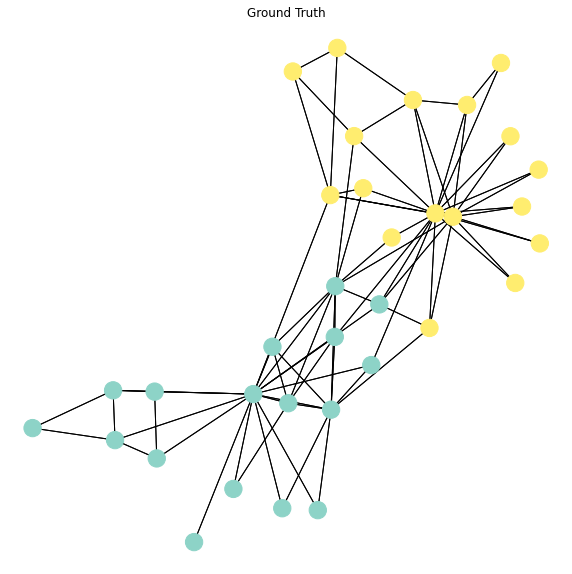

In [12]:
print_graph(utils_np.data_dicts_to_graphs_tuple([data_dict]), "Ground Truth")

In [13]:
graph_net_module = gn.modules.GraphNetwork(
    edge_model_fn=lambda: snt.nets.MLP([1]),
    node_model_fn=lambda: snt.nets.MLP([34, 34, 2]),
    global_model_fn=lambda: snt.nets.MLP([1]),
    edge_block_opt={'use_edges': False, 'use_receiver_nodes': True, 'use_sender_nodes': True, 'use_globals': False}, # Тут будем исспользовать только то, что нам нужно
    node_block_opt={'use_received_edges': True, 'use_nodes': True, 'use_globals': False, 'use_sent_edges': True},
    global_block_opt={'use_edges': True, 'use_nodes': True, 'use_globals': False},
)

In [14]:
a = 23423.53434564
str(round(a, 2))

'23423.53'

In [15]:
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)

In [16]:
def train(output_graphs, optimizer, steps_no=500, print_frequency=None):
  input_ph = utils_tf.placeholders_from_data_dicts([data_dict])
  output_graphs = graph_net_module(input_ph)
  input_ph = utils_tf.make_runnable_in_session(input_ph)
  
  loss = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=graphs_tuple.nodes, logits=output_graphs.nodes))
  step_op = optimizer.minimize(loss)
  
  sess = tf.Session()
  sess.run(tf.global_variables_initializer())

  output = utils_np.data_dicts_to_graphs_tuple([data_dict])
  losses, accuracies = [], []
  for i in range(steps_no):
    feed_dict = {input_ph: output}
    res = sess.run({"step_op": step_op, "output": output_graphs, "loss": loss}, feed_dict=feed_dict)
    losses.append(res["loss"])
    accuracy = np.mean(np.argmax(res["output"].nodes, axis=1) == np.argmax(data_dict["nodes"], axis=1))
    accuracies.append(accuracy)
    if print_frequency and i % print_frequency == 0:
      print_graph(res["output"], 'Step: %d, Loss: %.2E, Accuracy: %.2E' % (i, Decimal(res["loss"]), Decimal(accuracy)))
  
  return losses, accuracies


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

1.8356941540000662


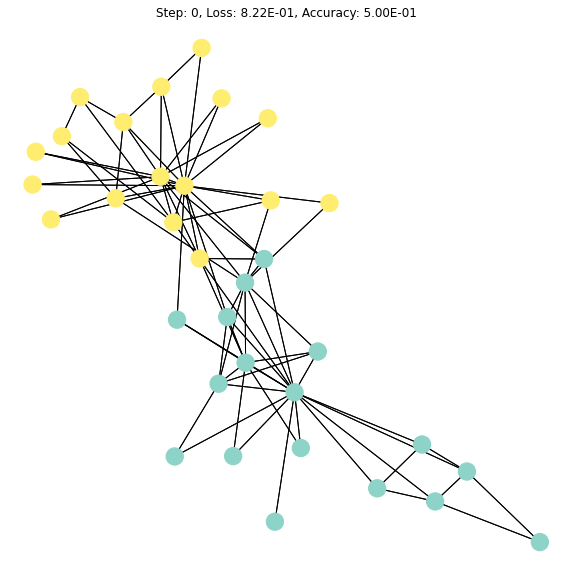

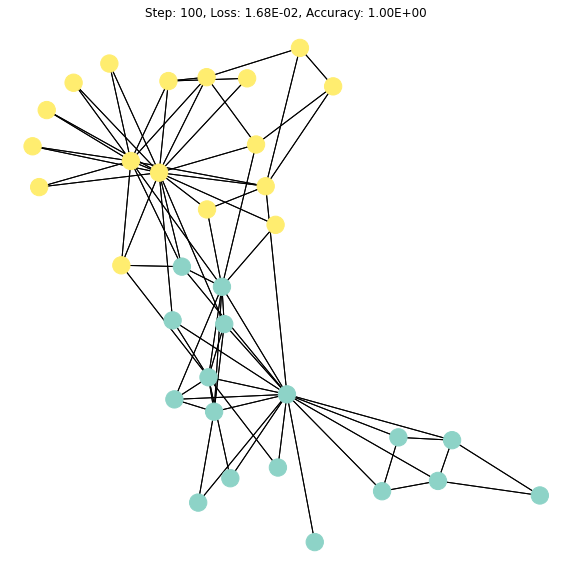

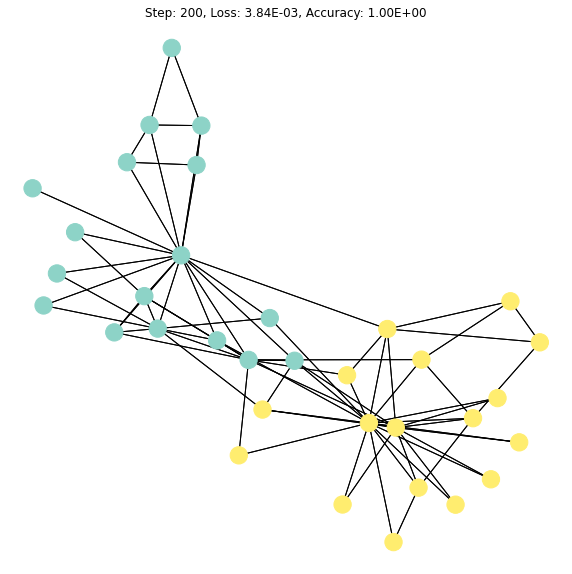

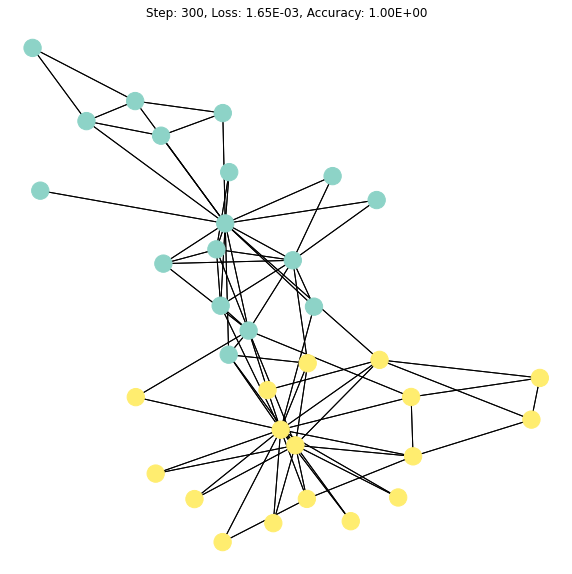

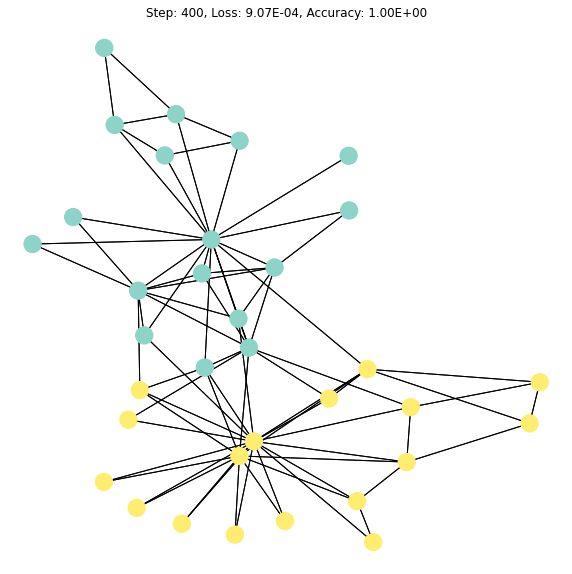

In [19]:
starttime = timeit.default_timer()
losses, accuracies = train(data_dict, optimizer, print_frequency=100)
print(timeit.default_timer()- starttime)

In [ ]:
losses, accuracies = [], []

for i in range(25):
  train_losses, train_accuracies = train(data_dict, optimizer)
  losses.append(train_losses)
  accuracies.append(train_accuracies)

In [ ]:
losses = np.array(losses)
accuracies = np.array(accuracies)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
max_values = np.max(losses, axis=0)
min_values = np.min(losses, axis=0)
mean_values = np.mean(losses, axis=0)

x = np.arange(0, losses.shape[1])
ax.plot(x, max_values, color="tab:blue")
ax.plot(x, min_values, color="tab:blue")
ax.plot(x, mean_values, color="tab:blue")
ax.fill_between(x, min_values, max_values, color="tab:blue", alpha=0.3)
ax.set_title("Loss")
ax.set_xlabel("Step")
ax.set_ylabel("Loss value")
ax.grid()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
max_values = np.max(accuracies, axis=0)
min_values = np.min(accuracies, axis=0)
mean_values = np.mean(accuracies, axis=0)

x = np.arange(0, accuracies.shape[1])
ax.plot(x, max_values, color="tab:red")
ax.plot(x, min_values, color="tab:red")
ax.plot(x, mean_values, color="tab:red")
ax.fill_between(x, min_values, max_values, color="tab:red", alpha=0.3)
ax.set_title("Accuracy")
ax.set_xlabel("Step")
ax.set_ylabel("Accuracy value")
ax.grid()